In [149]:
# importing of libaries
import numpy as np                      #functions for scientific computing, faster arrays
import pandas as pd                     #easy import and export of data, fast and easy-to-use datastructure
import math                             #mathematical functions
import matplotlib.pyplot as plt         #generation of Graphs
import seaborn as sns                   #generation of Graphs
from scipy.constants import pi, g       #fundamental Constants
import Leistung as lei                  #Eigenes Modul um Leistung und Fahrtwiderstaende zu berechnen                        

In [150]:
# document paths
path_data_idle1 = "data/idle1.csv"
path_data_drive1 = "data/drive1.csv"
path_data_live1 = "data/live1.csv"
path_data_ufpe1 = "data/ufpe1.csv"
path_data_long1 = "data/long1.csv"
graphs ="graphs/"

paths = (path_data_idle1, path_data_drive1, path_data_live1, path_data_ufpe1, path_data_long1)
length = len(paths)
data = list()  #list of pandas Dataframes
names = list() #list of the names of the data sets
for i in range(length):
    data.append(pd.read_csv(paths[i]))
    names.append(paths[i][5:-4]) #Abschneiden von data/ und .csv

In [151]:
# Constants
d_wheel = .583 #m Reifendurchmesser
#Source: https://tirewheelguide.de/sizes/toyota/etios-liva/2014/

In [152]:
# Wheel rotation from speed
# pV: speed in m/s
def n_Rad(pV):
    return (pV) / (d_wheel * pi)

In [153]:
for i in range(length):
    data[i]= data[i].assign(N_RAD = data[i]['VEHICLE_SPEED ()'].apply(n_Rad))

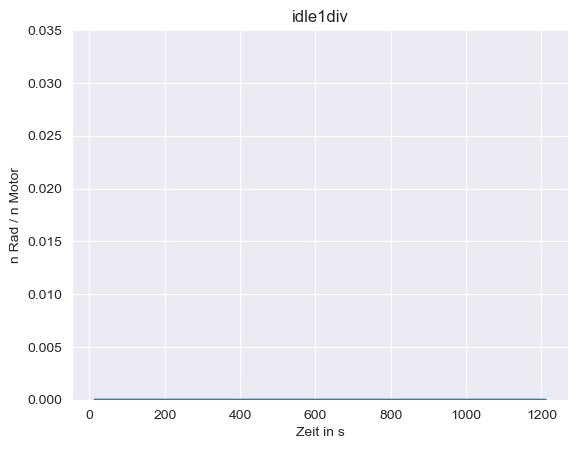

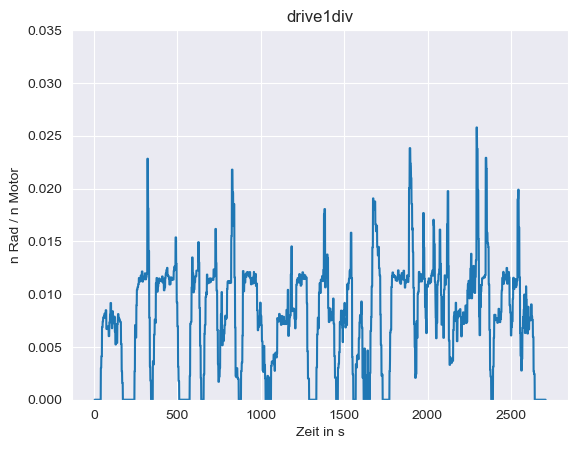

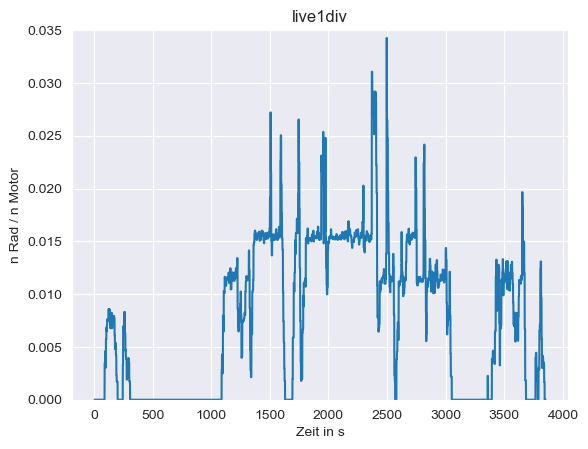

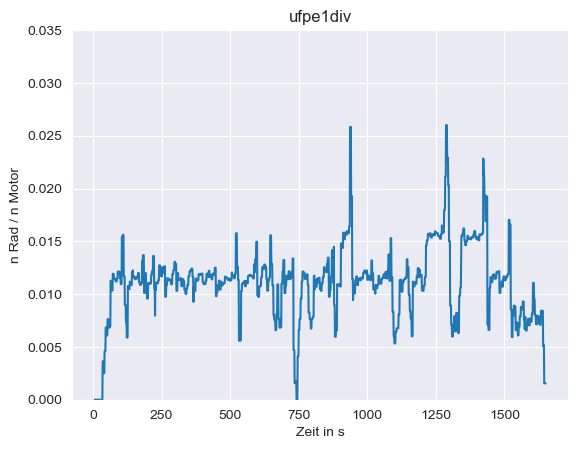

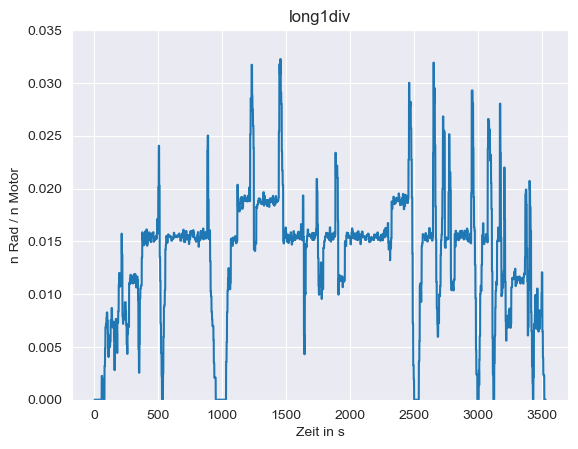

In [154]:
for i in range(length):
    local_length = int(data[i].shape[0])
    div = np.zeros(length)
    div = data[i]["N_RAD"]/data[i]["ENGINE_RPM ()"]
    plt.plot(div)
    plt.title(names[i]+"div")
    plt.xlabel("Zeit in s")
    plt.ylabel("n Rad / n Motor")
    plt.ylim(0, 0.035)
    plt.savefig(graphs+"div_"+names[i]+".png")
    plt.grid(True)
    plt.show()

weiteres vorgehen für die Bestimmung der Gänge, bereiche in denen sich die Drehzahl länger aufhält finden und für den x bereich den Durchschnitt bilden

## Beschleunigung

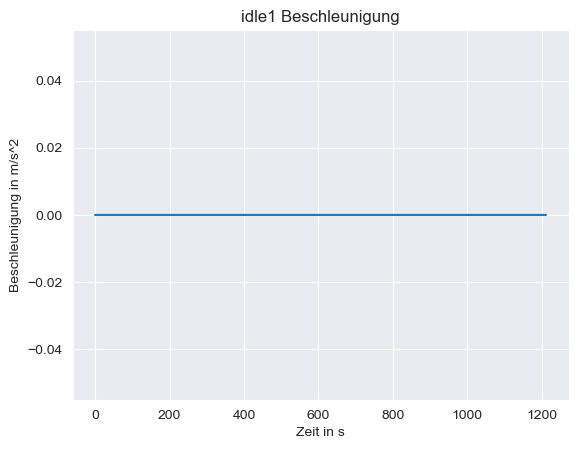

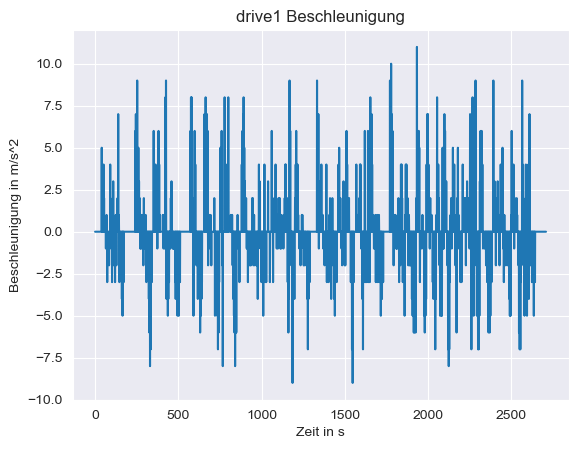

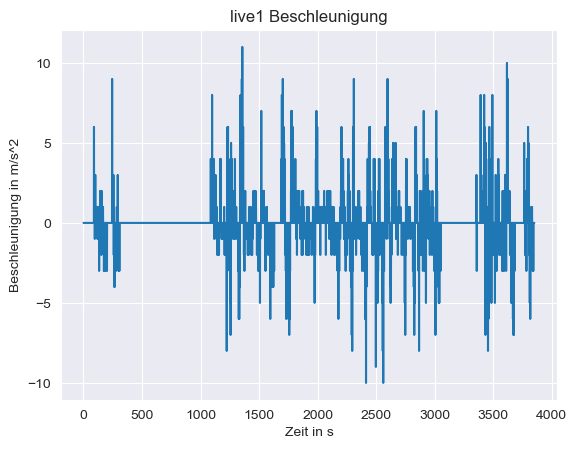

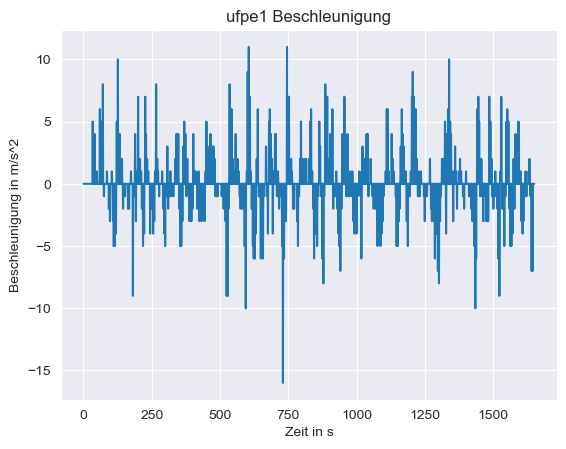

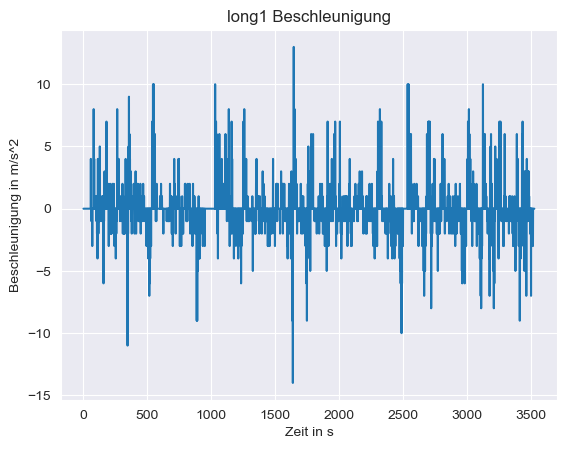

In [155]:
for i in range(length):   
    local_length = int(data[i].shape[0])
    acc =np.zeros(local_length)
    for j in range(local_length-1):
        acc[j]=data[i]["VEHICLE_SPEED ()"][j+1]-data[i]["VEHICLE_SPEED ()"][j] #teilen durch Zeit entfällt, da delta t = 1s
    
    data[i] = data[i].assign(BESCHLEUNIGUNG =acc)
    plt.plot(acc)
    plt.title(names[i]+" Beschleunigung")
    plt.xlabel("Zeit in s")
    plt.ylabel("Beschleunigung in m/s^2")
    plt.grid(True)
    plt.savefig(graphs+"beschleunigung_"+names[i]+".png")
    plt.show()

In [156]:
# zum test berechnung der Geschwindigkeit auf grundlage der ermittelten Beschleunigung
#gesch =np.zeros(length) 
#for i in range(length):
    #if 0 != i:
   #     gesch[i] = gesch[i-1]+acc[i-1] #mal zeit entfällt, da delta t = 1s
  #  else:
 #       gesch[i] = 0
#plt.plot(data_drive1["VEHICLE_SPEED ()"],color="orange",linewidth=4)
#plt.plot(gesch,color="blue",linewidth=1)
#plt.xlabel("Zeit in s")
#plt.ylabel("Geschwindigkeit")
#plt.grid(True)
#plt.savefig("gesch.png")
#plt.show()

In [157]:

def leistung_1(pDataframe):
    laenge = int(pDataframe.shape[0]) #Bestimmung der Laenge des Dataframes
    leist = np.zeros(laenge)
    for i in range(laenge-1):
        leist[i] = lei.leistung_1(pDataframe["VEHICLE_SPEED ()"][i],pDataframe["BESCHLEUNIGUNG"][i],0)
    return leist

In [158]:
for i in range(length):
    local_length = int(data[i].shape[0])
    leist = np.zeros(local_length)
    for j in range(local_length-1):
        leist[j] = lei.leistung_1(data[i]["VEHICLE_SPEED ()"][j],data[i]["BESCHLEUNIGUNG"][j],0) #Funktion zur Berechnung der Aktuellen Leistung
    data[i] = data[i].assign(LEISTUNG=leist)
    print(names[i]+" Leistung:")
    print("max: ", data[i]["LEISTUNG"].max()/1000,"kW\nmin: ",data[i]["LEISTUNG"].min()/1000,"kW")
    

idle1 Leistung:
max:  0.0 kW
min:  0.0 kW
drive1 Leistung:
max:  807.8112314268751 kW
min:  -510.38103615125 kW
live1 Leistung:
max:  918.2363026925002 kW
min:  -896.0097992481252 kW
ufpe1 Leistung:
max:  696.7701439825 kW
min:  -880.712043546875 kW
long1 Leistung:
max:  1359.7169565206252 kW
min:  -860.9921771343751 kW
